In [17]:
# Change this line if you're using Colab to something like '/content/drive/MyDrive/TeamX/'
# where TeamX is just the clone of repository on your Google Drive
# and you have mounted the drive at /content/drive  
# See the Tutorial Slides for more detail.

# Works on your local machine but not on Colab!
PROJECT_ROOT = '../..'

# Fix this path and use this one on Colab
# PROJECT_ROOT = '/content/drive/MyDrive/TeamX'

import sys
from os.path import join as ospj
sys.path.append(ospj(PROJECT_ROOT, 'src'))

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In this part of assignment 4 we try to
1. implement the forward pass of ViT
2. visualize the attention weights for the final CLS Token.


For evaluation and visualization, we use an 8-class subset (out of 1000) of Imagenet-V2. We use a subset, simply just so that you can run the cells faster.
The model is pre-trained and you just need to download the weights.

Furthermore, most of the relevant modules for ViT, such as the positional embedding, the linear projection, MLP Block, and Multi-head attention are all already implemented. What you mainly have to do is to plug these modules together based on what you've seen in lecture 7 (the ViT slides).

You probably shouldn't need GPU for running this assignment, as there is no training and the dataset is very small and every cell. But of course feel free to change the notebook so that it works on GPU if desired.

In [3]:
# from src/data_loaders/ import

In [107]:
import torch
import torchvision
import torchvision.transforms as transforms

from torchvision import datasets
from torch.utils.data import DataLoader

from matplotlib import pyplot as plt
from tqdm import tqdm 

from models.vit.model import VisionTransformer
from utils.imagenet_names import name_map
import numpy as np

## Downloading pre-trained weights

Please Download the weights from `https://download.pytorch.org/models/vit_b_16-c867db91.pth` and place it under `saved/models/vit/vit.pth`. The file size is 330M.


or you can just download and place it by running the cell below (tested on Linux).

In [5]:
# !wget "https://download.pytorch.org/models/vit_b_16-c867db91.pth"

# # Change the relative paths below to absolute if running on Colab
# !mkdir -p ../../saved/models/vit
# !mv vit_b_16-c867db91.pth ../../saved/models/vit/vit.pth

## Q1: ViT Inference (15 points)

For this part you need to complete the missing parts of the ViT model. 

<img src="../../data/exercise-4/ViT.png" width=1400 />

There are overall 6 `TODO Q1`s to be implemented for this question. 

You can of course define new attributes in the classes if you find it necessary. However, you cannot define new modules *with parameters* or change the name modules with parameters.
Otherwise, the `load_state_dict` will fail to match the weight values in the file with the code. Also changing the configs such as number of layers or dimensions would cause the same mismatch in loading weights.



In [26]:
weights = torch.load(ospj(PROJECT_ROOT,'saved/models/vit/vit.pth'))

model = VisionTransformer(
            image_size=224, # Input image size (width and height)
            patch_size=16,  # Image broken into (16 x 16) non-overlaping batches
            num_layers=12,  # Number of blocks in the Encoder
            num_heads=12,   # Number of heads in each Multi-"head" attention
            hidden_dim=768, # Token size (length of a single token)
            mlp_dim=3072,   # Hidden layer size of each MLP layer
        )

model.load_state_dict(weights, strict=True)

<All keys matched successfully>

Create the Dataset

We're using only 8 classes of Imagenet-V2 for this assignment. Feel free to checkout the entire dataset (https://github.com/modestyachts/ImageNetV2).

In [80]:
# Since we're just using a subset of classes, the labels that ImageFolder generates (starting from 0 to 7) 
# should be converted back to correct (0 to 999) numbers.
def label_convert(idx):
    class_subset = sorted([19, 330, 466, 558, 672, 716, 755, 986,])
    return class_subset[idx] # e.g. 0 -> 19, 2 -> 466


t = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Resize(256),
        transforms.CenterCrop(224),

        # Normalization is commented-out just for easier visualization below. Try putting it back if you failed the accuracy check.
        # transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)) 
    ]
)

dataset = datasets.ImageFolder(
        root=ospj(PROJECT_ROOT, 'data/exercise-4/Imagenet-V2-Subset'),
        transform=t, 
        target_transform=label_convert
    )
print(f"Test set is created with {len(dataset)} samples")

Test set is created with 80 samples


In [81]:
loader = DataLoader(
        dataset=dataset,
        drop_last=False,
        shuffle=False, 
        batch_size=8, # Change the batch size if the model doesn't fit into memory.
        num_workers=0,
        # multiprocessing_context="fork"
)

In [34]:
enumerate(loader)

In [82]:
num_correct = 0
total_cnt = 0
model.eval()

with torch.no_grad():
    for batch_idx, (images, targets) in tqdm(enumerate(loader), total=len(loader)):
        # print('here')
        out, attention_weights = model(images)
        pred = out.argmax(dim=1)

        num_correct += (pred == targets).sum()
        total_cnt += len(images)

top1_acc = 100*num_correct/total_cnt

  0%|          | 0/10 [00:00<?, ?it/s]/Users/muhammadovais/Downloads/HLCV/hlcv_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
100%|██████████| 10/10 [00:06<00:00,  1.46it/s]


In [83]:
print(f"Top-1 Acc on Test set is {100 * num_correct/total_cnt}")
assert top1_acc == 83.75, 'Accuracy does not match the expected value!'

Top-1 Acc on Test set is 83.75


# Visualize the Attention

Pick an image!

/Users/muhammadovais/Downloads/HLCV/hlcv_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


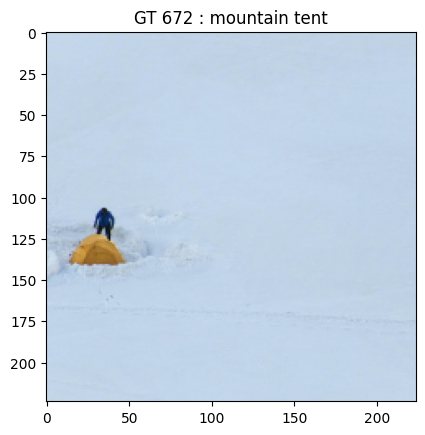

In [104]:
x, label = dataset[42]
plt.title(f"GT {label} : {name_map[label]}")
plt.imshow(x.moveaxis(0, -1))

torch.Size([1, 197, 197])
Predicted class 672 : mountain tent
torch.Size([14, 14, 1])


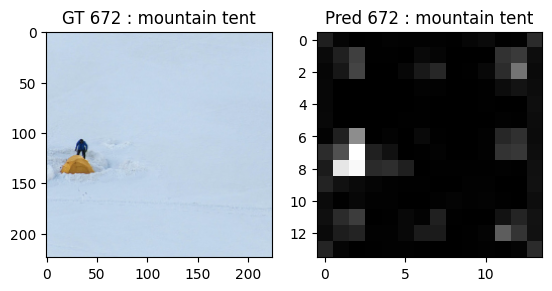

In [105]:
with torch.no_grad():
    output, attention_weights = model(x[None])

pred = output.argmax(dim=1).item()
print(f"Predicted class {pred} : {name_map[pred]}")

plt.subplot(1, 2, 1)
plt.imshow(x.moveaxis(0, -1))
plt.title(f"GT {label} : {name_map[label]}")
plt.subplot(1, 2, 2)
print(attention_weights[0].shape)
plt.imshow(attention_weights[0] , cmap='gray')
plt.title(f"Pred {pred} : {name_map[pred]}")
plt.show()

##### Trying out different images for answers below

torch.Size([1, 197, 197])
Predicted class 558 : flute, transverse flute
torch.Size([14, 14, 1])


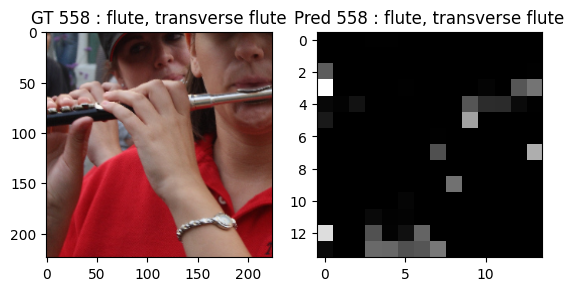

torch.Size([1, 197, 197])
Predicted class 716 : picket fence, paling
torch.Size([14, 14, 1])


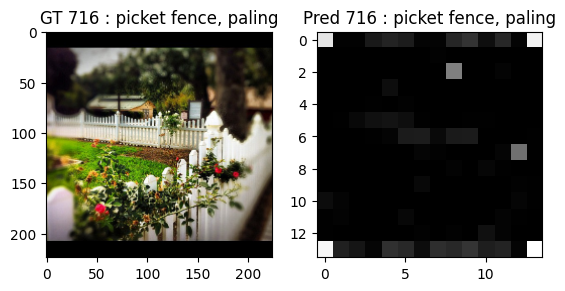

torch.Size([1, 197, 197])
Predicted class 330 : wood rabbit, cottontail, cottontail rabbit
torch.Size([14, 14, 1])


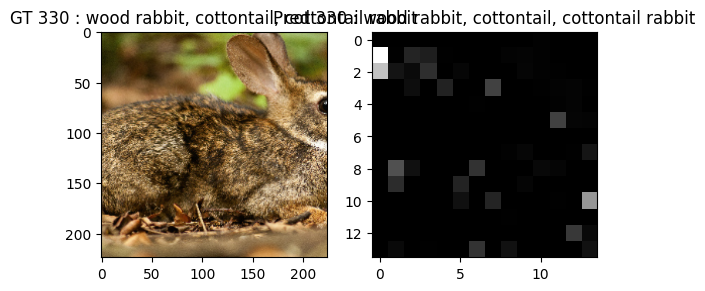

torch.Size([1, 197, 197])
Predicted class 336 : marmot
torch.Size([14, 14, 1])


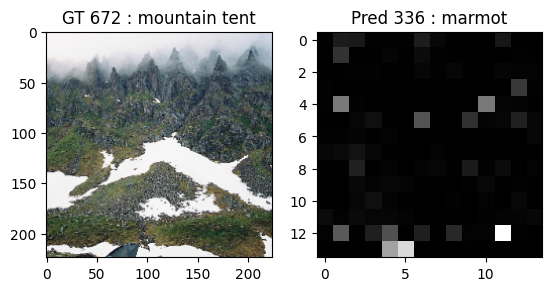

In [110]:
for idx in np.random.randint(0, 80, 4):
    x, label = dataset[idx]
    # plt.title(f"GT {label} : {name_map[label]}")
    # plt.imshow(x.moveaxis(0, -1))

    with torch.no_grad():
        output, attention_weights = model(x[None])

    pred = output.argmax(dim=1).item()
    print(f"Predicted class {pred} : {name_map[pred]}")

    plt.subplot(1, 2, 1)
    plt.imshow(x.moveaxis(0, -1))
    plt.title(f"GT {label} : {name_map[label]}")
    plt.subplot(1, 2, 2)
    print(attention_weights[0].shape)
    plt.imshow(attention_weights[0] , cmap='gray')
    plt.title(f"Pred {pred} : {name_map[pred]}")
    plt.show()

## Please briefly answer the following based on your intuition. (10 points)
1. Why does the attention map have lower resolution?  

   The attention map has a lower resolution because of the downsampling we did in our encoder by dividing the image into 16x16 patches. It's a 14x14 2D map where each attention value corresponds to the whole 16x16 patch of the image.  

2. Browse other samples of the dataset (simply change the idx above or add extra cells below). Is the attention map of final CLS token always localized on the object? Briefly explain your intuition behind what you see.  

   Not necessarily. The distribution of attention weights depends on the training data and the specific task our pretrained ViT was trained on. In general these weights represent the importance of each patch for making the final prediction. So if the model was trained on a diverse range of images and tasks, the attention map may exhibit a more distributed behaviour. On the other hand, if the the training data was designed exclusively for object-centric tasks (like detection or segmentation), then the attention map would be highly localized on the object.  

3. As mentioned above, we're visualizing the attention weights of the CLS token at the last layer.
   
   Can you think of any problems regarding this? 

   Can you come up with some other way of looking into a decision made by a transformer model?

   These attention maps of CLS token at the last layer layer are hard to interpret. They give an aggregated value for each patch which lacks any fine-scale information. So it just gives a general idea of the model's focus but doesn't help in developing a clear understanding of its decision-making.

   A multi-layer visualization would give a more comprehensive understanding on how the model attends to different patches in a hierarchical setting. An interesting notebook that uses this approach can be found <a href="https://www.kaggle.com/code/piantic/vision-transformer-vit-visualize-attention-map">here</a>

   In a classification problem like above, Class Activation Maps (CAM) and Gradient-based CAM (Grad-CAM) highlight the distinct regions in an image that contribute the most towards the model's arrival to the predicted output class by monitoring the gradient-flow into the model's layers. <a href="https://www.kaggle.com/code/basu369victor/covid19-detection-with-vit-and-heatmap">This notebook</a> is a great example for Grad-CAM.
   
    

